In [1]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA, KernelPCA
from sklearn.manifold import TSNE
from scipy.spatial import ConvexHull
from matplotlib import pyplot as plt
import inspect
from sklearn.model_selection import train_test_split


In [2]:
class ImageTransformer:
    """Transform features to an image matrix using dimensionality reduction
    This class takes in data normalized between 0 and 1 and converts it to a
    CNN compatible 'image' matrix
    """

    def __init__(self, feature_extractor='tsne', pixels=100,
                 random_state=None, n_jobs=None):
        """Generate an ImageTransformer instance
        Args:
            feature_extractor: string of value ('tsne', 'pca', 'kpca') or a
                class instance with method `fit_transform` that returns a
                2-dimensional array of extracted features.
            pixels: int (square matrix) or tuple of ints (height, width) that
                defines the size of the image matrix.
            random_state: int or RandomState. Determines the random number
                generator, if present, of a string defined feature_extractor.
            n_jobs: The number of parallel jobs to run for a string defined
                feature_extractor.
        """
        self.random_state = random_state
        self.n_jobs = n_jobs

        if isinstance(feature_extractor, str):
            fe = feature_extractor.casefold()
            if fe == 'tsne'.casefold():
                fe = TSNE(
                    n_components=2, metric='cosine',
                    random_state=self.random_state,
                    n_jobs=self.n_jobs)
            elif fe == 'pca'.casefold():
                fe = PCA(n_components=2,
                         random_state=self.random_state)
            elif fe == 'kpca'.casefold():
                fe = KernelPCA(
                    n_components=2, kernel='rbf',
                    random_state=self.random_state,
                    n_jobs=self.n_jobs)
            else:
                raise ValueError(("Feature extraction method '{}' not accepted"
                                  ).format(feature_extractor))
            self._fe = fe
        elif hasattr(feature_extractor, 'fit_transform') and \
                inspect.ismethod(feature_extractor.fit_transform):
            self._fe = feature_extractor
        else:
            raise TypeError('Parameter feature_extractor is not a '
                            'string nor has method "fit_transform"')

        if isinstance(pixels, int):
            pixels = (pixels, pixels)
        self._pixels = pixels
        self._xrot = None

    def fit(self, X, y=None, plot=False):
        """Train the image transformer from the training set (X)
        Args:
            X: {array-like, sparse matrix} of shape (n_samples, n_features)
            y: Ignored. Present for continuity with scikit-learn
            plot: boolean of whether to produce a scatter plot showing the
                feature reduction, hull points, and minimum bounding rectangle
        Returns:
            self: object
        """
        # perform dimensionality reduction
        x_new = self._fe.fit_transform(X.T)
        # get the convex hull for the points
        chvertices = ConvexHull(x_new).vertices
        hull_points = x_new[chvertices]
        # determine the minimum bounding rectangle
        mbr, mbr_rot = self._minimum_bounding_rectangle(hull_points)
        # rotate the matrix
        # save the rotated matrix in case user wants to change the pixel size
        self._xrot = np.dot(mbr_rot, x_new.T).T
        # determine feature coordinates based on pixel dimension
        self._calculate_coords()
        # plot rotation diagram if requested
        if plot is True:
            plt.scatter(x_new[:, 0], x_new[:, 1], s=1,
                        cmap=plt.cm.get_cmap("jet", 10), alpha=0.2)
            plt.fill(x_new[chvertices, 0], x_new[chvertices, 1],
                     edgecolor='r', fill=False)
            plt.fill(mbr[:, 0], mbr[:, 1], edgecolor='g', fill=False)
            plt.gca().set_aspect('equal', adjustable='box')
            plt.show()
        return self

    @property
    def pixels(self):
        """The image matrix dimensions
        Returns:
            tuple: the image matrix dimensions (height, width)
        """
        return self._pixels

    @pixels.setter
    def pixels(self, pixels):
        """Set the image matrix dimension
        Args:
            pixels: int or tuple with the dimensions (height, width)
            of the image matrix
        """
        if isinstance(pixels, int):
            pixels = (pixels, pixels)
        self._pixels = pixels
        # recalculate coordinates if already fit
        if hasattr(self, '_coords'):
            self._calculate_coords()

    def _calculate_coords(self):
        """Calculate the matrix coordinates of each feature based on the
        pixel dimensions.
        """
        ax0_coord = np.digitize(
            self._xrot[:, 0],
            bins=np.linspace(min(self._xrot[:, 0]), max(self._xrot[:, 0]),
                             self._pixels[0])
        ) - 1
        ax1_coord = np.digitize(
            self._xrot[:, 1],
            bins=np.linspace(min(self._xrot[:, 1]), max(self._xrot[:, 1]),
                             self._pixels[1])
        ) - 1
        self._coords = np.stack((ax0_coord, ax1_coord), axis=1)

    def transform(self, X, format='rgb', empty_value=0):
        """Transform the input matrix into image matrices
        Args:
            X: {array-like, sparse matrix} of shape (n_samples, n_features)
                where n_features matches the training set.
            format: The format of the image matrix to return. 'scalar' return a
                array of shape (M, N). 'rgb' returns an numpy.ndarray of shape
                (M, N, 3) that is compatible with PIL.
            empty_value: numeric value to fill elements where no features are
                mapped. Default = 0.
        Returns:
            A list of n_samples numpy matrices of dimensions set by
            the pixel parameter
        """
        img_coords = pd.DataFrame(np.vstack((
            self._coords.T,
            X
        )).T).groupby([0, 1], as_index=False).mean()

        img_matrices = []
        blank_mat = np.zeros(self._pixels)
        if empty_value != 0:
            blank_mat[:] = empty_value
        for z in range(2, img_coords.shape[1]):
            img_matrix = blank_mat.copy()
            img_matrix[img_coords[0].astype(int),
                       img_coords[1].astype(int)] = img_coords[z]
            img_matrices.append(img_matrix)

        if format=='rgb':
            img_matrices = np.array([self._mat_to_rgb(m) for m in img_matrices])
        elif format=='scalar':
            img_matrices = np.stack(img_matrices)
        else:
            raise ValueError(("'{}' not accepted for parameter 'format'")
                             .format(format))

        return img_matrices

    def fit_transform(self, X, **kwargs):
        """Train the image transformer from the training set (X) and return
        the transformed data.
        Args:
            X: {array-like, sparse matrix} of shape (n_samples, n_features)
        Returns:
            A list of n_samples numpy matrices of dimensions set by
            the pixel parameter
        """
        self.fit(X)
        return self.transform(X, **kwargs)

    def feature_density_matrix(self):
        """Generate image matrix with feature counts per pixel
        Returns:
            img_matrix (ndarray): matrix with feature counts per pixel
        """
        fdmat = np.zeros(self._pixels)
        np.add.at(fdmat, tuple(self._coords.T), 1)
        return fdmat

    def coords(self):
        """Get feature coordinates
        Returns:
            ndarray: the pixel coordinates for features
        """
        return self._coords.copy()

    @staticmethod
    def _minimum_bounding_rectangle(hull_points):
        """Find the smallest bounding rectangle for a set of points.
        Modified from JesseBuesking at https://stackoverflow.com/a/33619018
        Returns a set of points representing the corners of the bounding box.
        Args:
            hull_points : an nx2 matrix of hull coordinates
        Returns:
            (tuple): tuple containing
                coords (ndarray): coordinates of the corners of the rectangle
                rotmat (ndarray): rotation matrix to align edges of rectangle
                    to x and y
        """

        pi2 = np.pi / 2
        # calculate edge angles
        edges = hull_points[1:] - hull_points[:-1]
        angles = np.arctan2(edges[:, 1], edges[:, 0])
        angles = np.abs(np.mod(angles, pi2))
        angles = np.unique(angles)
        # find rotation matrices
        rotations = np.vstack([
            np.cos(angles),
            -np.sin(angles),
            np.sin(angles),
            np.cos(angles)]).T
        rotations = rotations.reshape((-1, 2, 2))
        # apply rotations to the hull
        rot_points = np.dot(rotations, hull_points.T)
        # find the bounding points
        min_x = np.nanmin(rot_points[:, 0], axis=1)
        max_x = np.nanmax(rot_points[:, 0], axis=1)
        min_y = np.nanmin(rot_points[:, 1], axis=1)
        max_y = np.nanmax(rot_points[:, 1], axis=1)
        # find the box with the best area
        areas = (max_x - min_x) * (max_y - min_y)
        best_idx = np.argmin(areas)
        # return the best box
        x1 = max_x[best_idx]
        x2 = min_x[best_idx]
        y1 = max_y[best_idx]
        y2 = min_y[best_idx]
        rotmat = rotations[best_idx]
        # generate coordinates
        coords = np.zeros((4, 2))
        coords[0] = np.dot([x1, y2], rotmat)
        coords[1] = np.dot([x2, y2], rotmat)
        coords[2] = np.dot([x2, y1], rotmat)
        coords[3] = np.dot([x1, y1], rotmat)

        return coords, rotmat

    @staticmethod
    def _mat_to_rgb(mat):
        """Convert image matrix to numpy rgb format
        Args:
            mat: {array-like} (M, N)
        Returns:
            An numpy.ndarry (M, N, 3) with orignal values repeated across
            RGB channels.
        """
        return np.repeat(mat[:, :, np.newaxis], 3, axis=2)


class LogScaler:
    """Log normalize and scale data
    Log normalization and scaling procedure as described as norm-2 in the
    DeepInsight paper supplementary information.
    """

    def __init__(self):
        self._min0 = None
        self._max = None
        pass

    def fit(self, X, y=None):
        self._min0 = X.min(axis=0)
        self._max = np.log(X + np.abs(self._min0) + 1).max()

    def fit_transform(self, X, y=None):
        self._min0 = X.min(axis=0)
        X_norm = np.log(X + np.abs(self._min0) + 1)
        self._max = X_norm.max()
        return X_norm / self._max

    def transform(self, X, y=None):
        X_norm = np.log(X + np.abs(self._min0) + 1).clip(0, None)
        return (X_norm / self._max).clip(0, 1)

In [4]:
df = pd.read_csv("/content/sample_data/churn.csv")
y = df['churn'].values
X = df.iloc[:, 1:].values

In [5]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

In [6]:
le=LabelEncoder()# to transform the target variable
y= le.fit_transform(y)
print(y)

[0 0 0 ... 0 0 0]


In [7]:
le_x=LabelEncoder()
X[:,1]=le.fit_transform(X[:,1])
X[:,2]=le.fit_transform(X[:,2])
print(X)

[[128 0 1 ... 3 2.7 1]
 [107 0 1 ... 3 3.7 1]
 [137 0 0 ... 5 3.29 0]
 ...
 [61 0 0 ... 4 3.67 1]
 [109 0 0 ... 6 2.3 0]
 [86 0 1 ... 16 2.51 0]]


In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=23)

In [9]:
from sklearn.preprocessing import MinMaxScaler
mmsc = MinMaxScaler()
X_train_norm = mmsc.fit_transform(X_train)
X_test_norm = mmsc.transform(X_test).clip(0,1)

In [10]:
tsne = TSNE(
    n_components=2,
    random_state=23,
    n_jobs=-1)

In [11]:
it = ImageTransformer(
    feature_extractor=tsne, 
    pixels=32)

In [12]:
X_train_img = it.fit_transform(X_train_norm)
X_test_img = it.transform(X_test_norm)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


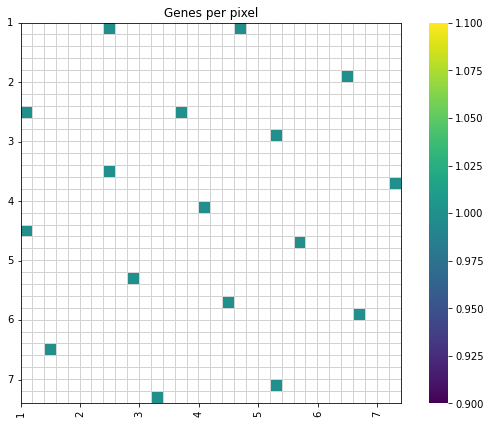

In [13]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

fdm = it.feature_density_matrix()
fdm[fdm == 0] = np.nan

plt.figure(figsize=(10, 7))

ax = sns.heatmap(fdm, cmap="viridis", linewidths=0.01, 
                 linecolor="lightgrey", square=True)
ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
ax.yaxis.set_major_locator(ticker.MultipleLocator(5))
for _, spine in ax.spines.items():
    spine.set_visible(True)
_ = plt.title("Genes per pixel")

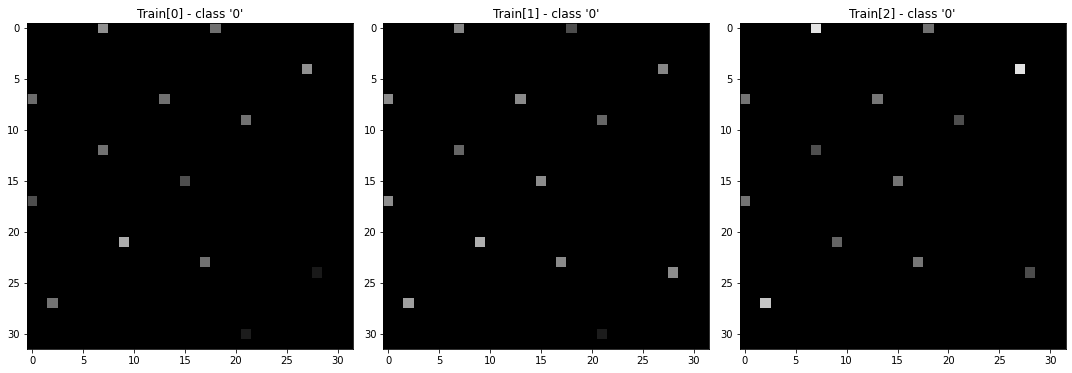

In [14]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for i in range(0,3):
    ax[i].imshow(X_train_img[i])
    ax[i].title.set_text("Train[{}] - class '{}'".format(i, y_train[i]))
plt.tight_layout()

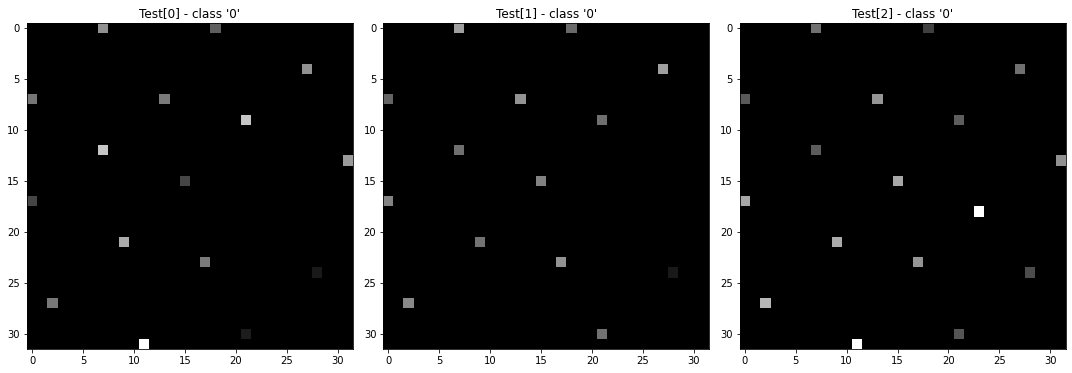

In [15]:
X_test_img = it.transform(X_test_norm)

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for i in range(0,3):
    ax[i].imshow(X_test_img[i])
    ax[i].title.set_text("Test[{}] - class '{}'".format(i, y_test[i]))
plt.tight_layout()

In [16]:
import torch

In [17]:
device = torch.device("cpu")
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.optim as optim

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

import warnings; 
warnings.simplefilter('ignore')

In [18]:
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)
num_classes = np.unique(y_train_enc).size

In [19]:
net = torch.hub.load(
    'pytorch/vision:v0.6.0', 'squeezenet1_1', 
    pretrained=False, verbose=False).double()
net.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), 
                              stride=(1,1)).double()

Downloading: "https://github.com/pytorch/vision/archive/v0.6.0.zip" to /root/.cache/torch/hub/v0.6.0.zip


In [20]:
preprocess = transforms.Compose([
    transforms.ToTensor()
])

In [21]:
X_train_tensor = torch.stack([preprocess(img) for img in X_train_img])
y_train_tensor = torch.from_numpy(le.fit_transform(y_train))

X_test_tensor = torch.stack([preprocess(img) for img in X_test_img])
y_test_tensor = torch.from_numpy(le.transform(y_test))

In [22]:
batch_size = 1

trainset = TensorDataset(X_train_tensor, y_train_tensor)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)

In [23]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=1e-4, momentum=0.9)

In [24]:
for epoch in range(20):

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    # print epoch statistics
    print('[%d] loss: %.3f' %
          (epoch + 1, running_loss / len(X_train_tensor) * batch_size))

[1] loss: 0.417
[2] loss: 0.345
[3] loss: 0.310
[4] loss: 0.297
[5] loss: 0.283
[6] loss: 0.277
[7] loss: 0.273
[8] loss: 0.268
[9] loss: 0.271
[10] loss: 0.262
[11] loss: 0.257
[12] loss: 0.253
[13] loss: 0.249
[14] loss: 0.243
[15] loss: 0.243
[16] loss: 0.242
[17] loss: 0.234
[18] loss: 0.233
[19] loss: 0.232
[20] loss: 0.227


In [25]:
train_outputs = net(X_train_tensor)
_, train_predicted = torch.max(train_outputs, 1)

In [26]:
test_outputs = net(X_test_tensor)
_, test_predicted = torch.max(test_outputs, 1)

In [27]:
print("The train accuracy was {:.3f}".format(accuracy_score(train_predicted, y_train_tensor)))
print("The test accuracy was {:.3f}".format(accuracy_score(test_predicted, y_test_tensor)))

The train accuracy was 0.923
The test accuracy was 0.910
